![imagen](https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/15b4b6b851f9044910f7912d9d3d0282421a3f11/sesiones/sesion11/resources/BANNER_SESIONSEMILLERO.png)

In [1]:
!pip install -q -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 772.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 17.6 MB/s eta 0:00:00


In [2]:
#@title Import necessary modules

import torch
import requests
import ipywidgets as widgets

from transformers import (
    BlipProcessor, BlipForQuestionAnswering,
    ViltProcessor, ViltForQuestionAnswering,
    Blip2Processor, Blip2ForConditionalGeneration
)

from PIL import Image
from io import BytesIO
from IPython.display import display
from ipywidgets import Output, VBox, Layout, Text, Button

In [3]:
from huggingface_hub.utils import disable_progress_bars

disable_progress_bars()
print("Hugging Face Hub progress bars disabled via utility function.")

Hugging Face Hub progress bars disabled via utility function.


In [4]:
# @title **Utils**

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def load_image(url):
    """Load image from URL with error handling"""
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        return Image.open(BytesIO(response.content)).convert("RGB")
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

Using device: cpu


In [5]:
# @title 1. VQA (Visual Question Answering) Comparison

def initialize_models(configs):
    """Initialize models with proper device placement"""
    models = []
    for cfg in configs:
        try:
            print(f"Loading {cfg['name']}...")
            processor = cfg['processor_class'].from_pretrained(cfg['model_id'])

            model = cfg['model_class'].from_pretrained(cfg['model_id']).to(device)

            model.eval()
            models.append({**cfg, 'processor': processor, 'model': model})
            print(f"Successfully loaded {cfg['name']}")
        except Exception as e:
            print(f"Failed to load {cfg['name']}: {e}")
            models.append({**cfg, 'processor': None, 'model': None})
    return models

# Model configurations
MODEL_CONFIGS = [
    {
        "name": "BLIP-base",
        "model_id": "Salesforce/blip-vqa-base",
        "processor_class": BlipProcessor,
        "model_class": BlipForQuestionAnswering,
    },
    {
        "name": "VILT",
        "model_id": "dandelin/vilt-b32-finetuned-vqa",
        "processor_class": ViltProcessor,
        "model_class": ViltForQuestionAnswering,
    }
]

# Initialize models
vqa_models = initialize_models(MODEL_CONFIGS)

# UI Components
def create_widgets():
    """Create and return interactive widgets"""
    style = {'description_width': 'initial'}
    layout = Layout(width='95%')

    return {
        'url_input': widgets.Text(
            value="http://images.cocodataset.org/val2017/000000039769.jpg",
            placeholder='Image URL',
            description='Image URL:',
            style=style,
            layout=layout
        ),
        'question_input': widgets.Text(
            value="How many cats are on the bed?",
            placeholder='Enter question',
            description='Question:',
            style=style,
            layout=layout
        ),
        'run_button': widgets.Button(
            description="Analyze Image",
            button_style='info',
            layout=Layout(width='200px')
        )
    }

def process_vilt(model, processor, image, question):
    """Process VILT model queries"""
    inputs = processor(image, question, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return model.config.id2label[outputs.logits.argmax(-1).item()]

def process_blip(model, processor, image, question):
    """Process BLIP model queries"""
    inputs = processor(image, question, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=10)
    return processor.decode(outputs[0], skip_special_tokens=True)

def analyze_image(b):
    """Main analysis function"""
    with output_area:
        output_area.clear_output()
        url = widgets['url_input'].value
        question = widgets['question_input'].value

        if not url or not question:
            print("Please provide both image URL and question")
            return

        image = load_image(url)
        if not image:
            print(f"Failed to load image from {url}")
            return

        # Display preview
        image.thumbnail((300, 300))
        display(image)
        print(f"\nQuestion: {question}\n")

        # Process models
        results = []
        for cfg in vqa_models:
            if not cfg['model']:
                results.append((cfg['name'], "Model not loaded"))
                continue

            try:
                if "VILT" in cfg['name']:
                    answer = process_vilt(cfg['model'], cfg['processor'], image, question)
                else:
                    answer = process_blip(cfg['model'], cfg['processor'], image, question)

                results.append((cfg['name'], answer))
            except Exception as e:
                results.append((cfg['name'], f"Error: {str(e)}"))

        # Display results
        print("\nResults:")
        for name, ans in results:
            print(f"{name:<15} | {ans}")

# Setup UI
widgets = create_widgets()
widgets['run_button'].on_click(analyze_image)
output_area = Output()

display(VBox([
    widgets['url_input'],
    widgets['question_input'],
    widgets['run_button'],
    output_area
], layout=Layout(width='70%', margin='20px auto')))

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading BLIP-base...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Successfully loaded BLIP-base
Loading VILT...
Successfully loaded VILT


Enter URL of an artwork (or press enter to use default): https://upload.wikimedia.org/wikipedia/commons/thumb/1/1b/Claude_Monet_-_Woman_with_a_Parasol_-_Madame_Monet_and_Her_Son_-_Google_Art_Project.jpg/1200px-Claude_Monet_-_Woman_with_a_Parasol_-_Madame_Monet_and_Her_Son_-_Google_Art_Project.jpg

Art Style Analysis:
Image URL: https://upload.wikimedia.org/wikipedia/commons/thumb/1/1b/Claude_Monet_-_Woman_with_a_Parasol_-_Madame_Monet_and_Her_Son_-_Google_Art_Project.jpg/1200px-Claude_Monet_-_Woman_with_a_Parasol_-_Madame_Monet_and_Her_Son_-_Google_Art_Project.jpg
Renaissance               1.3%
Impressionist             97.8%
Cubist                    0.1%
Surrealist                0.4%
Pop Art                   0.0%
Abstract Expressionist    0.0%
digital artwork           0.2%
photograph                0.1%


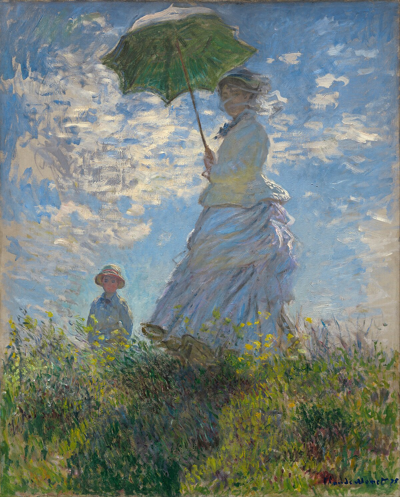

In [6]:
# @title 2. Zero-shot classification with CLIP
from transformers import CLIPProcessor, CLIPModel

# Load model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Load image
art_url = input("Enter URL of an artwork (or press enter to use default): ").strip()
if not art_url:
    art_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1200px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"

image = load_image(art_url)
if image is None:
    raise ValueError("Failed to load image from the provided URL")

# Art style categories
styles = [
    "a painting in Renaissance style",
    "a painting in Impressionist style",
    "a painting in Cubist style",
    "a painting in Surrealist style",
    "a painting in Pop Art style",
    "a painting in Abstract Expressionist style",
    "a digital artwork",
    "a photograph"
]

# Process inputs
inputs = processor(
    text=styles,
    images=image,
    return_tensors="pt",
    padding=True
)

# Compute similarity
outputs = model(**inputs)
probs = outputs.logits_per_image.softmax(dim=1)[0]

# Display results
print("\nArt Style Analysis:")
print(f"Image URL: {art_url}")
for style, prob in zip(styles, probs):
    # More robust string processing
    style_name = style.replace("a painting in ", "").replace("a ", "").split(" style")[0]
    print(f"{style_name:<25} {prob.item()*100:.1f}%")

# Show the image
display(image.resize((400, int(400 * image.size[1]/image.size[0]))))

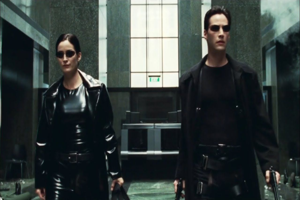


Image: https://static1.colliderimages.com/wordpress/wp-content/uploads/2021/09/the-matrix.jpeg
Correct: The Matrix
Predicted: The Matrix (99.8%)
All predictions:
  The Matrix      99.8%
  Inception       0.1%
  The Avengers    0.1%
  Titanic         0.0%
  Jurassic Park   0.0%
  Star Wars       0.0%
--------------------------------------------------


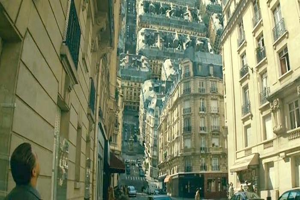


Image: https://i.redd.it/xehwtk6u9eo31.jpg
Correct: Inception
Predicted: Inception (95.8%)
All predictions:
  The Matrix      3.5%
  Inception       95.8%
  The Avengers    0.5%
  Titanic         0.1%
  Jurassic Park   0.0%
  Star Wars       0.1%
--------------------------------------------------


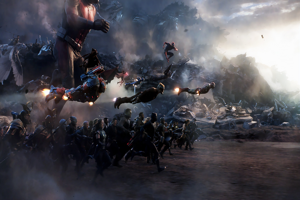


Image: https://i.redd.it/xunujzgylj731.jpg
Correct: The Avengers
Predicted: The Avengers (96.0%)
All predictions:
  The Matrix      0.2%
  Inception       0.2%
  The Avengers    96.0%
  Titanic         0.0%
  Jurassic Park   0.0%
  Star Wars       3.6%
--------------------------------------------------


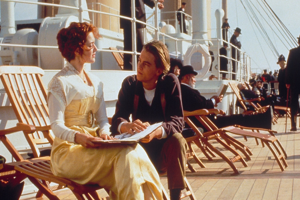


Image: https://www.intofilm.org/intofilm-production/scaledcropped/970x546https%3A/s3-eu-west-1.amazonaws.com/images.cdn.filmclub.org/film__3136-titanic--hi_res-5b7cb696.jpg/film__3136-titanic--hi_res-5b7cb696.jpg
Correct: Titanic
Predicted: Titanic (100.0%)
All predictions:
  The Matrix      0.0%
  Inception       0.0%
  The Avengers    0.0%
  Titanic         100.0%
  Jurassic Park   0.0%
  Star Wars       0.0%
--------------------------------------------------


In [8]:
# Load model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Define image loading function
def load_image(url):
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raises an error for bad responses
        return Image.open(response.raw).convert("RGB")
    except Exception as e:
        print(f"Error loading image from {url}: {str(e)}")
        return None

# Working movie frames with correct answers (using real image URLs)
movie_frames = {
    "https://static1.colliderimages.com/wordpress/wp-content/uploads/2021/09/the-matrix.jpeg": "The Matrix",
    "https://i.redd.it/xehwtk6u9eo31.jpg": "Inception",
    "https://i.redd.it/xunujzgylj731.jpg": "The Avengers",
    "https://www.intofilm.org/intofilm-production/scaledcropped/970x546https%3A/s3-eu-west-1.amazonaws.com/images.cdn.filmclub.org/film__3136-titanic--hi_res-5b7cb696.jpg/film__3136-titanic--hi_res-5b7cb696.jpg": "Titanic"
}

# Movie options
movies = [
    "a scene from The Matrix",
    "a scene from Inception",
    "a scene from The Avengers",
    "a scene from Titanic",
    "a scene from Jurassic Park",
    "a scene from Star Wars"
]

# Test each frame
for img_url, correct_answer in movie_frames.items():
    image = load_image(img_url)
    if image is None:
        continue  # Skip if image couldn't be loaded

    # Display the image
    display(image.resize((300, 200)))

    # Process inputs
    inputs = processor(
        text=movies,
        images=image,
        return_tensors="pt",
        padding=True
    )

    # Compute similarity
    outputs = model(**inputs)
    probs = outputs.logits_per_image.softmax(dim=1)[0]

    # Get top prediction
    top_prob, top_idx = torch.max(probs, 0)
    predicted_movie = movies[top_idx].split("from ")[1]

    print(f"\nImage: {img_url}")
    print(f"Correct: {correct_answer}")
    print(f"Predicted: {predicted_movie} ({top_prob.item()*100:.1f}%)")
    print("All predictions:")
    for movie, prob in zip(movies, probs):
        print(f"  {movie.split('from ')[1]:<15} {prob.item()*100:.1f}%")
    print("-" * 50)

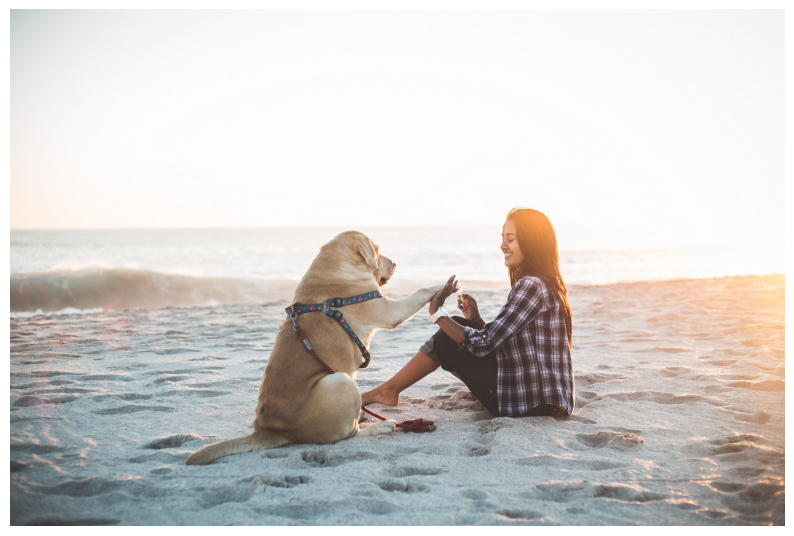


Prompt: Question: What is happening in this image? First identify objects, then describe the scene. Answer:
Step 1: In the image, there is a man and a woman sitting on a bench, both holding a dog.
Step 2: The man is holding the dog's leash, while the woman is holding a cup..

Prompt: Question: If the dog stands up, what might happen next? Reason step by step. Answer:
Step 1: The dog might stand up and walk towards the person.
Step 2: The person can then pet the dog and continue the conversation..

Prompt: Question: How might the person in the image be feeling? Look at their posture and surroundings to explain. Answer:
Step 1: The person in this image is sitting on the ground, with their legs crossed and their arms resting on their knees.
Step 2: They appear to be relaxed and comfortable.
Step 3: This suggests that they might be feeling content and at ease in their surroundings..


In [9]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoProcessor, AutoModelForVision2Seq

# Load Kosmos-2
processor = AutoProcessor.from_pretrained("microsoft/kosmos-2-patch14-224")
model = AutoModelForVision2Seq.from_pretrained(
    "microsoft/kosmos-2-patch14-224",
    torch_dtype=torch.float16
).to(device)

try:
    img_url = "https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg"
    image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
    print("Please upload an image named 'demo.jpg' to your Colab workspace")
    raise

# Display image
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.axis('off')
plt.show()

# Define complex reasoning prompts
reasoning_prompts = [
    "<grounding>Question: What is happening in this image? First identify objects, then describe the scene. Answer:",
    "<grounding>Question: If the dog stands up, what might happen next? Reason step by step. Answer:",
    "<grounding>Question: How might the person in the image be feeling? Look at their posture and surroundings to explain. Answer:"
]

def clean_kosmos_output(text):
    """Remove raw <object> tags while keeping the descriptive text"""
    import re
    text = re.sub(r'<object><patch_index_\d+><patch_index_\d+></object>', '', text)
    text = re.sub(r'<phrase>(.*?)</phrase>', r'\1', text)
    return text

# Run reasoning
for prompt in reasoning_prompts:
    print(f"\nPrompt: {prompt.replace('<grounding>', '')}")

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch.float16)

    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=150,
            do_sample=False,
        )

    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Clean and format the output
    cleaned_text = clean_kosmos_output(generated_text)

    # Print formatted reasoning steps
    if "Answer:" in cleaned_text:
        answer = cleaned_text.split("Answer:")[1].strip()
        for i, line in enumerate(answer.split(". ")):
            if line and not line.startswith("<"):
                print(f"Step {i+1}: {line.strip()}.")
    else:
        print(cleaned_text)